# 必要なライブラリの読み込み

In [ ]:
# 数値計算用ライブラリ numpy をインポート
import numpy as np

# データフレームを提供するライブラリ pandas をインポート
import pandas as pd

# ディープラーニング用フレームワーク、TensorFlow から
# keras 及び keras 以下のモジュールをインポート
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10

# 描画用ライブラリをインポート
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec, cm

# 混合行列作成用メソッド confusion_matrix をインポート
from sklearn.metrics import confusion_matrix

# データセットを読み込み（CIFAR-10）

In [ ]:
# CIFAR-10 データセットを読み込み
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


### 3.画像を表示

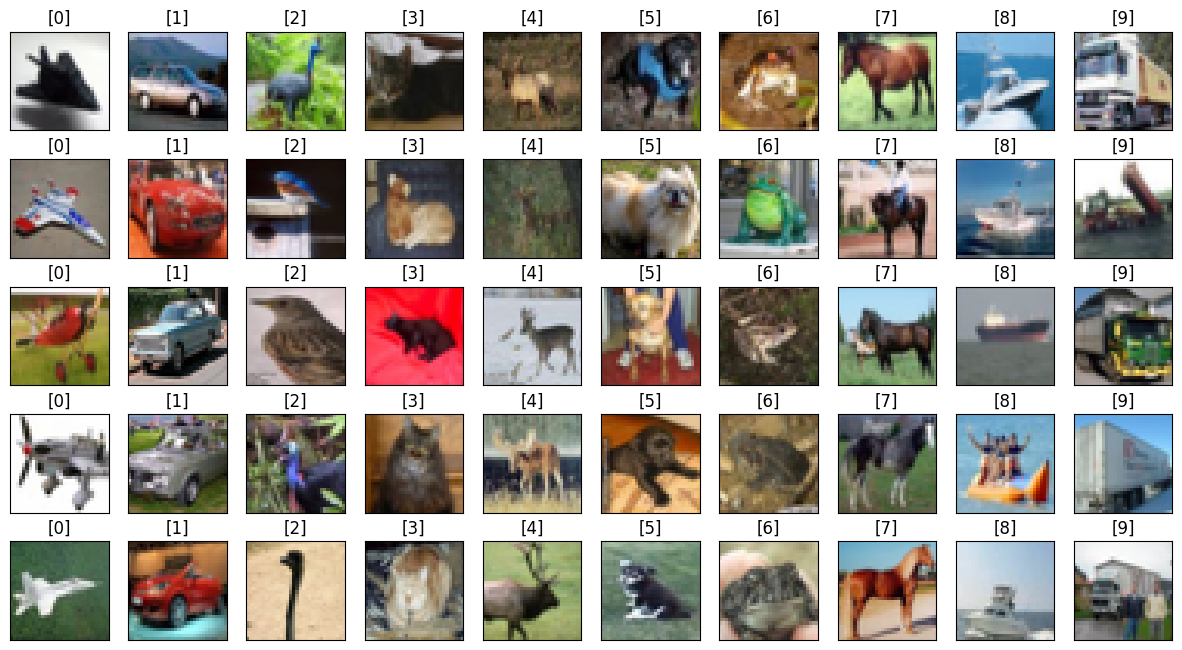

In [ ]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(5,10) # 格子状に複数のsubplotを描画する
for i in range(10):
  index = np.where(y_train==i)[0][:5] # 正解ラベルiのサンプルを5個選んでデータ番号を取得
  for j in range(5):
    ax = plt.subplot(gs[j, i])
    ax.imshow(X_train[index[j],:,:], 'gray')
    ax.set_title(y_train[index[j]])
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
print(X_train.shape)

(50000, 32, 32, 3)


# モデルを作成

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(32, 32, 3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['sparse_categorical_accuracy'])

# 訓練を実行する

In [ ]:
# ジェネレータを定義する
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             horizontal_flip=False,
                             vertical_flip=False
                             )
datagen.fit(X_train)

# 訓練を実行（訓練しながら ImageDataGenerator が機能し、Data Augumentation を行っている）
batch_size = 256
valid_samples = 5000
train_samples = len(X_train) - valid_samples
mc = ModelCheckpoint("cnn_best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=15)
hist = model.fit(datagen.flow(X_train[:train_samples], y_train[:train_samples], batch_size=batch_size),
                 steps_per_epoch = train_samples / batch_size, # steps_per_epoch：何回行うと学習データを一巡したことになるかを指定
                 epochs=10,
                 callbacks=[mc, es],
                 validation_data=datagen.flow(X_train[-valid_samples:], y_train[-valid_samples:], batch_size=batch_size),
                 validation_steps = valid_samples / batch_size # steps_per_epoch：何回行うと学習データを一巡したことになるかを指定
                 )

Epoch 1/10
176/175 [==============================] - ETA: 0s - loss: 4.6616 - sparse_categorical_accuracy: 0.1523
Epoch 1: val_loss improved from inf to 2.13613, saving model to cnn_best_model.h5
175/175 [==============================] - 147s 822ms/step - loss: 4.6616 - sparse_categorical_accuracy: 0.1523 - val_loss: 2.1361 - val_sparse_categorical_accuracy: 0.1998
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/175 [==============================] - ETA: 0s - loss: 2.1646 - sparse_categorical_accuracy: 0.1665
Epoch 2: val_loss improved from 2.13613 to 2.05079, saving model to cnn_best_model.h5
175/175 [==============================] - 141s 798ms/step - loss: 2.1646 - sparse_categorical_accuracy: 0.1665 - val_loss: 2.0508 - val_sparse_categorical_accuracy: 0.2310
Epoch 3/10
176/175 [==============================] - ETA: 0s - loss: 2.1317 - sparse_categorical_accuracy: 0.1749
Epoch 3: val_loss improved from 2.05079 to 1.99571, saving model to cnn_best_model.h5
175/175 [==============================] - 138s 783ms/step - loss: 2.1317 - sparse_categorical_accuracy: 0.1749 - val_loss: 1.9957 - val_sparse_categorical_accuracy: 0.2452
Epoch 4/10
176/175 [==============================] - ETA: 0s - loss: 2.0937 - sparse_categorical_accuracy: 0.1835
Epoch 4: val_loss improved from 1.99571 to 1.91183, saving model to cnn_best_model.h5
175/175 [==============================] - 137s 777ms/step - l

# 結果の確認

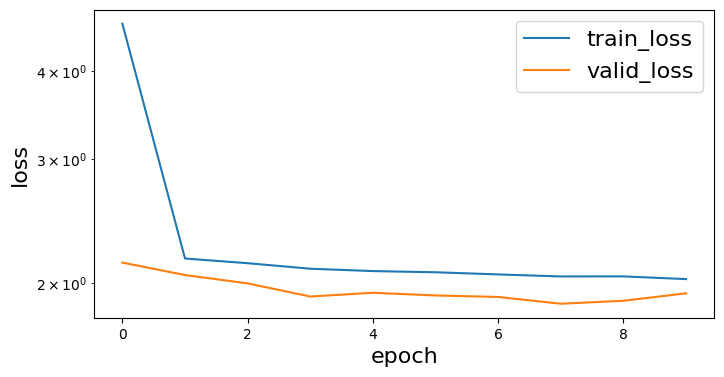

In [ ]:
# 訓練履歴をプロット
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.figure(figsize=(8, 4))
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(val_loss)), val_loss, label='valid_loss')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
plt.show()

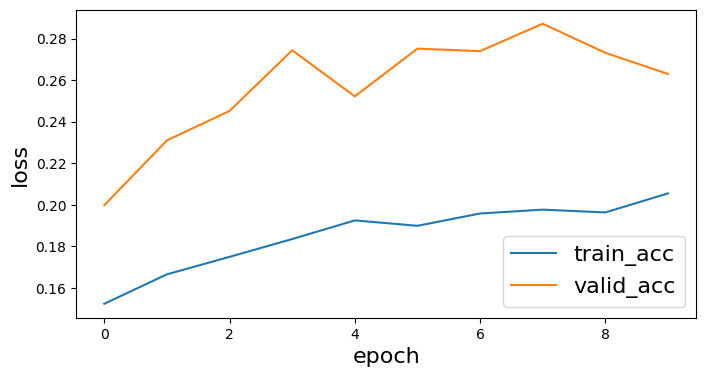

In [ ]:
train_loss = hist.history["sparse_categorical_accuracy"]
val_loss = hist.history["val_sparse_categorical_accuracy"]

plt.figure(figsize=(8, 4))
plt.plot(range(len(train_loss)), train_loss, label='train_acc')
plt.plot(range(len(val_loss)), val_loss, label='valid_acc')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
# ベストモデルの読み込み
model = load_model('cnn_best_model.h5')

# ベストモデルのlossと精度
model.evaluate(X_test, y_test)

313/313 [==============================] - 9s 28ms/step - loss: 1.8309 - sparse_categorical_accuracy: 0.2931


[1.830946445465088, 0.2930999994277954]

313/313 [==============================] - 7s 23ms/step


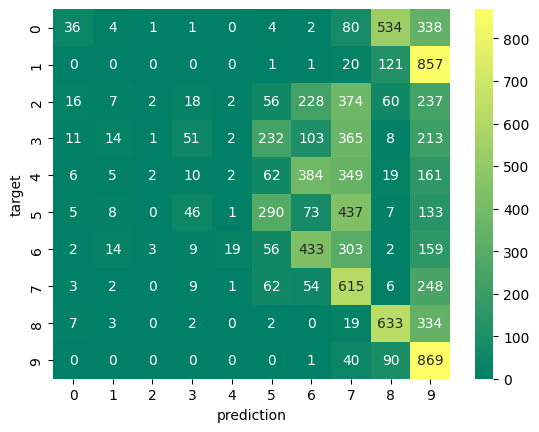

In [ ]:
# 予測結果を取得
y_pred = np.argmax(model.predict(X_test),axis=1)

# 混同行列を作成
cnf_matrix = confusion_matrix(y_test, y_pred)

# 混同行列を描画
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel("prediction")
plt.ylabel("target")
plt.show()